## [Forecasting I: univariate, heavy tailed](http://pyro.ai/examples/forecasting_i.html#Forecasting-I:-univariate,-heavy-tailed)

In [1]:
import torch

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps

from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile

import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.8.3')
pyro.set_rng_seed(20200221)

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


#### Pyro’s forecasting framework consists of: - a ForecastingModel base class, whose .model() method can be implemented for custom forecasting models, - a Forecaster class that trains and forecasts using ForecastingModels, and - a backtest() helper to evaluate models on a number of metrics.

##### a simple univariate dataset, say weekly BART train ridership aggregated over all stations in the network. 

In [3]:
T, O, D = dataset['counts'].shape

In [4]:
T // (24 * 7) * 24 * 7

78792

In [5]:
data = dataset['counts'][:T // (24 * 7) * 24 * 7].reshape(T // (24*7), -1).sum(-1).log()

In [6]:
data = data.unsqueeze(-1)

In [7]:
data.shape

torch.Size([469, 1])

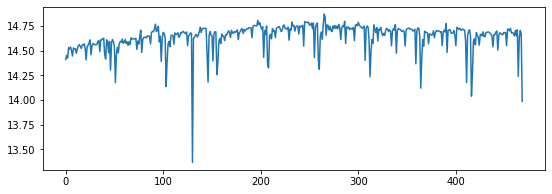

In [8]:
plt.figure(figsize=(9,3))
plt.plot(data)

In [9]:
class Model_1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        bias = pyro.sample('bias', dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample('weight',  dist.Normal(0,0.1).expand([feature_dim]).to_event(1))
        predicttion = bias + (weight * covariates).sum(-1, keepdim = True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert predicttion.shape[-2:] == zero_data.shape

        noise_scale = pyro.sample('noise_scale',  dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        self.predict(noise_dist, predicttion)

In [10]:
T0 = 0
T2 = data.size(-2)
T1 = T2 - 52

In [11]:
T2

469

In [12]:
time = torch.arange(float(T2)) / 365

In [13]:
time.shape

torch.Size([469])

In [14]:
covariates = torch.stack([time], dim=-1)

In [15]:
covariates.shape

torch.Size([469, 1])

In [16]:
data[:T1].size(-1)

1

In [17]:
%%time
pyro.set_rng_seed(111)
pyro.clear_param_store()

forecaster = Forecaster(Model_1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 74.955
INFO 	 step  100 loss = 3.36581
INFO 	 step  200 loss = -0.0438504
INFO 	 step  300 loss = -0.572852
INFO 	 step  400 loss = -0.572043
INFO 	 step  500 loss = -0.608833
INFO 	 step  600 loss = -0.608717
INFO 	 step  700 loss = -0.5981
INFO 	 step  800 loss = -0.597871
INFO 	 step  900 loss = -0.611214
INFO 	 step 1000 loss = -0.604468


CPU times: user 5.38 s, sys: 0 ns, total: 5.38 s
Wall time: 5.77 s


####  Drawing posterior samples from the forecaster, passing in full covariates but only partial data. 

In [18]:
samples = forecaster(data[:T1], covariates, num_samples=1000)

In [19]:
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)

In [20]:
p10

tensor([14.5584, 14.5521, 14.5646, 14.5403, 14.5573, 14.5470, 14.5724, 14.5597,
        14.5601, 14.5692, 14.5603, 14.5691, 14.5629, 14.5736, 14.5585, 14.5643,
        14.5570, 14.5686, 14.5642, 14.5743, 14.5665, 14.5615, 14.5721, 14.5634,
        14.5618, 14.5541, 14.5735, 14.5644, 14.5817, 14.5656, 14.5792, 14.5692,
        14.5707, 14.5762, 14.5541, 14.5652, 14.5706, 14.5745, 14.5765, 14.5596,
        14.5736, 14.5842, 14.5744, 14.5731, 14.5815, 14.5722, 14.5754, 14.5714,
        14.5791, 14.5722, 14.5724, 14.5894])

 [Continuous Ranked Probability Score](https://www.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf)

In [21]:
crps = eval_crps(samples, data[T1:])

In [22]:
print(samples.shape, p10.shape)

torch.Size([1000, 52, 1]) torch.Size([52])


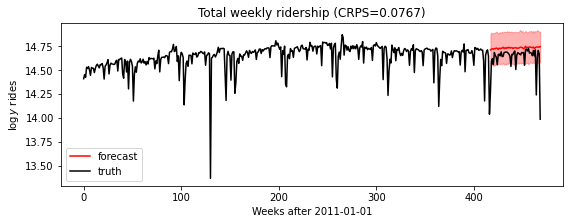

In [23]:
plt.figure(figsize=(9,3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.ylabel('$\log y$ rides')
plt.xlabel('Weeks after 2011-01-01')
plt.title('Total weekly ridership (CRPS={:0.3g})'.format(crps))
plt.legend(loc='best')

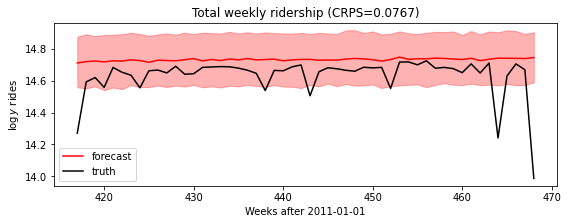

In [24]:
plt.figure(figsize=(9,3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.ylabel('$\log y$ rides')
plt.xlabel('Weeks after 2011-01-01')
plt.title('Total weekly ridership (CRPS={:0.3g})'.format(crps))
plt.legend(loc='best')

### Adding Periodic Features

In [25]:
periodic_features(T2, 365.25/7).shape

torch.Size([469, 52])

In [26]:
time.unsqueeze(-1).shape

torch.Size([469, 1])

In [27]:
covariates = torch.cat([time.unsqueeze(-1), periodic_features(T2, 365 / 7)], dim=-1)

In [28]:
covariates.shape

torch.Size([469, 53])

In [29]:
covariates.shape[-1]

53

In [30]:
%%time
pyro.set_rng_seed(111)
pyro.clear_param_store()

forecaster = Forecaster(Model_1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 4.09608e+09
INFO 	 step  100 loss = 12.9749
INFO 	 step  200 loss = 1.70743
INFO 	 step  300 loss = -0.022353
INFO 	 step  400 loss = -0.402364
INFO 	 step  500 loss = -0.578822
INFO 	 step  600 loss = -0.49775
INFO 	 step  700 loss = -0.517555
INFO 	 step  800 loss = -0.569014
INFO 	 step  900 loss = -0.558331
INFO 	 step 1000 loss = -0.585292


CPU times: user 5.33 s, sys: 0 ns, total: 5.33 s
Wall time: 5.33 s


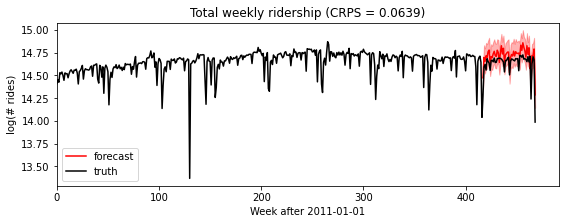

In [31]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

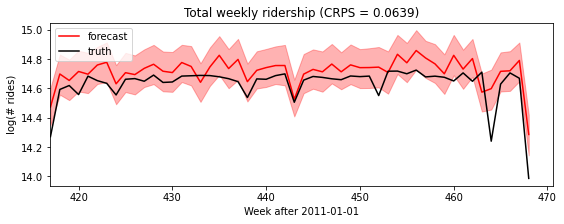

In [32]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

### [Time-local random variables](http://pyro.ai/examples/forecasting_i.html#Time-local-random-variables:-self.time_plate)

In [33]:
pyro.sample('bias', dist.Normal(0, 10).expand([10]).to_event(1))

tensor([  8.5880, -14.3378,  11.4732,  -6.6912,  -0.2426,   4.5080, -14.2452,
          3.4863,   6.5257,   2.8224])

In [34]:
pyro.sample('drift_scale', 
                                        dist.LogNormal(-20, 5).expand([1]).to_event(1))

tensor([7.5118e-08])

In [39]:
class Model_2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample('bias', dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample('weight', dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        # time-global scale parameter
        drift_scale = pyro.sample('drift_scale', 
                                        dist.LogNormal(-20, 5).expand([1]).to_event(1))
        
        # time-local iid noise inside time plate
        with self.time_plate:
        # We'll use a reparameterizer to improve variational fit. The model would still be
        # correct if you removed this context manager, but the fit appears to be worse. 
            with poutine.reparam(config={'drift': LocScaleReparam()}):
                drift = pyro.sample('drift', dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.   

        motion = drift.cumsum(-2) # A Brownian motion
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim = True)
        assert prediction.shape[-2:] == zero_data.shape
        noise_scale = pyro.sample('noise_scale', dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist=noise_dist, prediction=prediction)


In [40]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model_2(), data[:T1], covariates[:T1], learning_rate=0.1,
                        time_reparam="dct",
                       )

INFO 	 step    0 loss = 1.73259e+09
INFO 	 step  100 loss = 1.08769
INFO 	 step  200 loss = -0.0379667
INFO 	 step  300 loss = -0.128441
INFO 	 step  400 loss = -0.230683
INFO 	 step  500 loss = -0.363375
INFO 	 step  600 loss = -0.335997
INFO 	 step  700 loss = -0.405325
INFO 	 step  800 loss = -0.450079
INFO 	 step  900 loss = -0.483642
INFO 	 step 1000 loss = -0.526827


CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


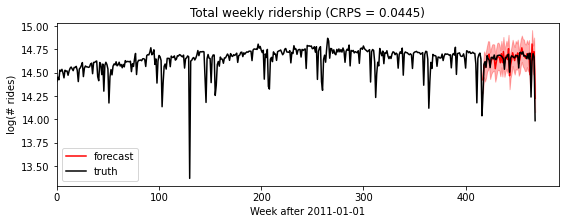

In [41]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

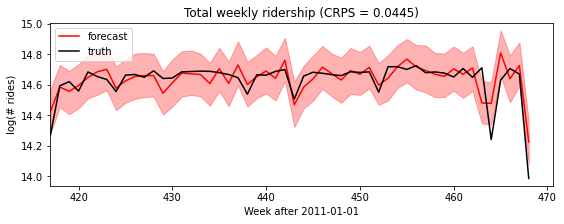

In [42]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

### [Heavy-tailed noise](http://pyro.ai/examples/forecasting_i.html#Heavy-tailed-noise)